### Introduction

As we discussed in the exploratory analysis notebook, the space of our images is quite different from the space of the images present in ImageNet. Whereas ImageNet images are clear with little occlusion, making it straightforward to associate an image with its label, our dataset of camera trap images are highly occluded. One of the main challenges is the fact that animals are only partially captured in the frame (due to the automated capture system). This means that often times, there is very little signal to properly identify an image with its label. This is made worse by the relatively low resolution of such automated camera systems, as well as factors such as motion blur, light saturation from flash (during nighttime captures), obstruction caused by the natural environment (e.g. trees, bushes, leaves, etc.) that further distract from the discriminative signal we need for classification. Thus, it is dubious whether feature representations learned from ImageNet images will help much, if at all, for this classification task.

Thus, we start by developing a small custom convolutional neural network model, from scratch.

In [1]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# Directory to save models
model_dir = pathlib.Path('../bin/custom/')

2025-01-26 14:27:35.853850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 14:27:36.079126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737919656.175912     624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737919656.200996     624 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:27:36.405251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Defining our model architecture and overfitting

We'll start by defining a CNN architecture that should still be big enough to overfit our data. Our data is relatively small (~12k training examples), so our CNN model does not need to be very large. We will define a model with 5 convolutional layers (including max pooling layers) that are increasing in filter size and 3 fully connected (dense) layers. Additionally, we will have a `Rescaling` layer at the start to standardize our pixel features. We will create a function that will define this architecture and return an instance of the model, since we will reuse this architecture when tuning parameters.

In [2]:
def make_vanilla_model():
    inputs = keras.Input(shape=(150, 150, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(8, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

We will generate `tf.data.Dataset` objects for each of each of the data splits from the directory structure, using `tensorflow.keras.utils.image_dataset_from_directory`. Thus, the labels will be inferred from the directory structure, and will be indices corresponding to each of the 8 labels. Thus, we will use the sparse version of the categorical cross entropy loss function. Additionally, we will use the `Adam` optimizer with the default learning rate of `1e-3`, and for metrics, we will compute accuracy, as discussed in the exploratory data analysis notebook. We will compile the model with these settings.

In [3]:
model = make_vanilla_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

I0000 00:00:1737854331.077180   85468 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Now, we will set create our train, validation, and test datasets from our previously created directory structure. We will also set `batch_size` to 32 for now.

In [72]:
new_base_dir = pathlib.Path("../species_data")

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(150, 150),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'valid',
    image_size=(150, 150),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(150, 150),
    batch_size=32
)

Found 11540 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.


Now, we will set up a callback function for model checkpointing, and fit our model for 30 epochs. Since we have a decently large model for our problem with no regularization, our model should overfit the training data.

In [5]:
model_path = pathlib.Path('custom_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1737854334.855332   85599 service.cc:148] XLA service 0x7fefdc025a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737854334.855375   85599 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-01-25 20:18:54.898617: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737854335.058090   85599 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-25 20:18:55.127145: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 14/361 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1096 - loss: 2.0840

I0000 00:00:1737854338.007306   85599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.1908 - loss: 1.9942 - val_accuracy: 0.3816 - val_loss: 1.5954
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3875 - loss: 1.5636 - val_accuracy: 0.5085 - val_loss: 1.3238
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5237 - loss: 1.2618 - val_accuracy: 0.5954 - val_loss: 1.0902
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6467 - loss: 0.9581 - val_accuracy: 0.6621 - val_loss: 0.9168
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7338 - loss: 0.7480 - val_accuracy: 0.7304 - val_loss: 0.7670
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7842 - loss: 0.5821 - val_accuracy: 0.7595 - val_loss: 0.6928
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8333 - loss: 0.4733 - val_accuracy: 0.7583 - val_loss: 0.7067
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8534 - loss: 0.4044 - val_accuracy: 0.75

Let's define a function to plot our results, and plot the accuracy and loss curves for our model above.

In [6]:
def plot_accuracy_and_loss(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    ax1 = axes.flat[0]
    ax1.plot(epochs, history.history['accuracy'], color='b', marker='.', label='Training accuracy')
    ax1.plot(epochs, history.history['val_accuracy'], color='r', marker='.', label='Validation accuracy')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and validation accuracy')
    ax1.grid(True)
    ax2 = axes.flat[1]
    ax2.plot(epochs, history.history['loss'], color='b', marker='.', label='Training loss')
    ax2.plot(epochs, history.history['val_loss'], color='r', marker='.', label='Validation loss')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and validation loss')
    ax2.grid(True)
    plt.show()

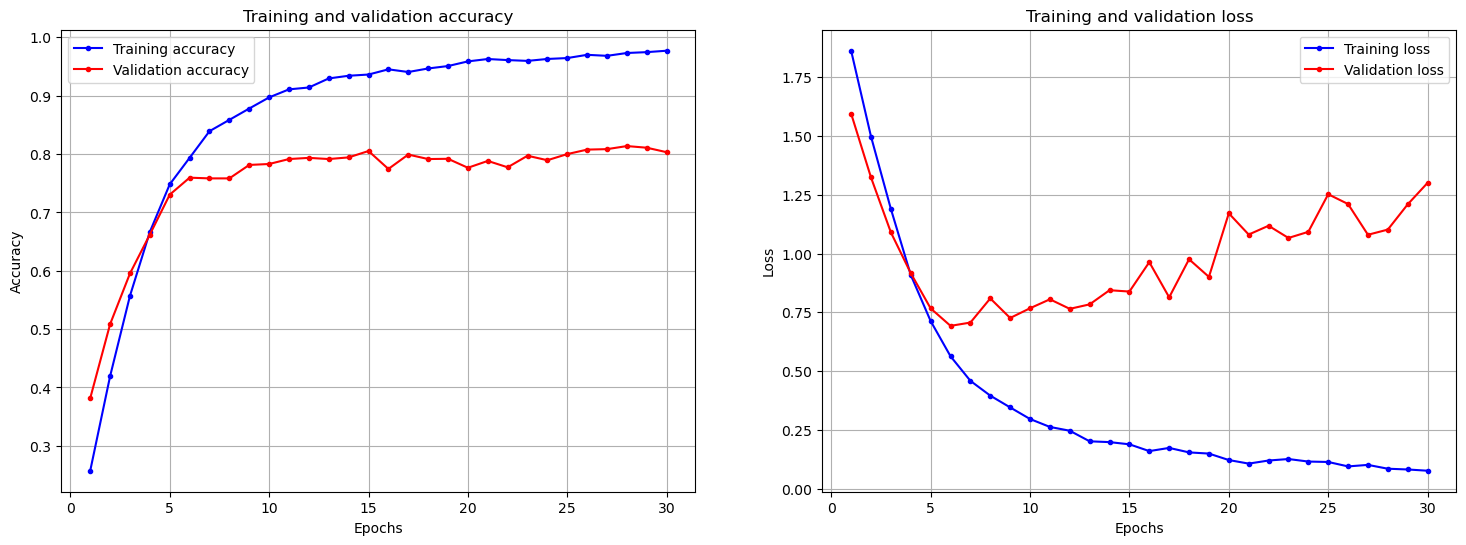

In [7]:
plot_accuracy_and_loss(history)

Evidently, our training accuracy goes to 1, while our training loss goes to 0, and thus, we are able to overfit our model. Now, we need to add measures to regularize our model. In addition, we will tune the parameters of these regularizers (e.g. learning rate, batch size, dropout probability, etc.).

### Regularizing our model and tuning hyperparameters

#### Learning rate

Let's start by trying to vary our learning rate. Since the `Adam` optimizer uses a default learning rate of `1e-3`, and we are overfitting in this setting, we will try smaller learning rates. In particular, we can try the following values: `[1e-5, 1e-4, 5e-4]`. Let's train our first model with `learning_rate=1e-5` for 400 epochs instead of 100.

In [18]:
model = make_vanilla_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_lr_1e-5_v3_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=400,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1454 - loss: 2.0675 - val_accuracy: 0.1520 - val_loss: 2.0351
Epoch 2/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2034 - loss: 2.0101 - val_accuracy: 0.3076 - val_loss: 1.9028
Epoch 3/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3023 - loss: 1.8671 - val_accuracy: 0.3124 - val_loss: 1.7619
Epoch 4/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3161 - loss: 1.7488 - val_accuracy: 0.3294 - val_loss: 1.7067
Epoch 5/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3392 - loss: 1.6882 - val_accuracy: 0.3662 - val_loss: 1.6527
Epoch 6/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3630 - loss: 1.6468 - val_accuracy: 0.3597 - val_loss: 1.6308
Epoch 7/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3753 - loss: 1.6181 - val_accuracy: 0.3800 - val_loss: 1.5999
Epoch 8/400
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3902 - loss: 1.5886 - 

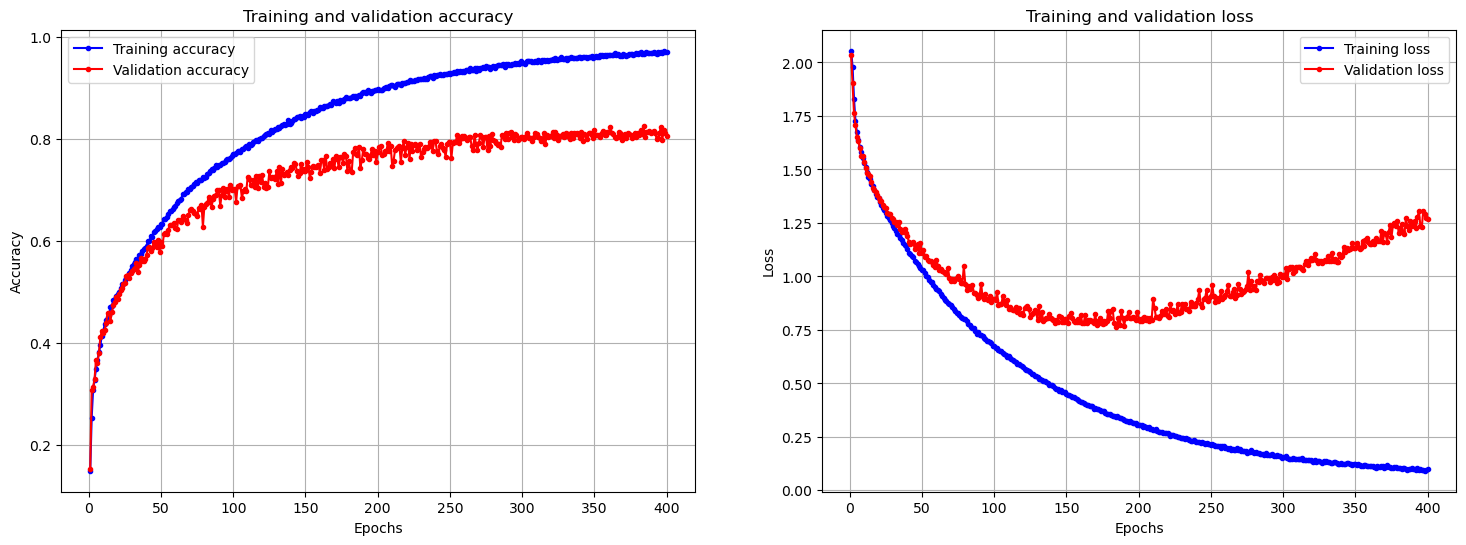

In [19]:
plot_accuracy_and_loss(history)

Now we'll train our second model with `learning_rate=1e-4`.

In [11]:
model = make_vanilla_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_lr_1e-4_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2133 - loss: 1.9852 - val_accuracy: 0.2902 - val_loss: 1.7061
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3479 - loss: 1.6411 - val_accuracy: 0.4107 - val_loss: 1.5526
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4329 - loss: 1.4919 - val_accuracy: 0.4697 - val_loss: 1.4062
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4992 - loss: 1.3627 - val_accuracy: 0.5057 - val_loss: 1.3016
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5479 - loss: 1.2246 - val_accuracy: 0.5513 - val_loss: 1.2268
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5949 - loss: 1.1282 - val_accuracy: 0.6006 - val_loss: 1.1191
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6431 - loss: 1.0130 - val_accuracy: 0.5816 - val_loss: 1.1519
Epoch 8/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6756 - loss: 0.9261 - 

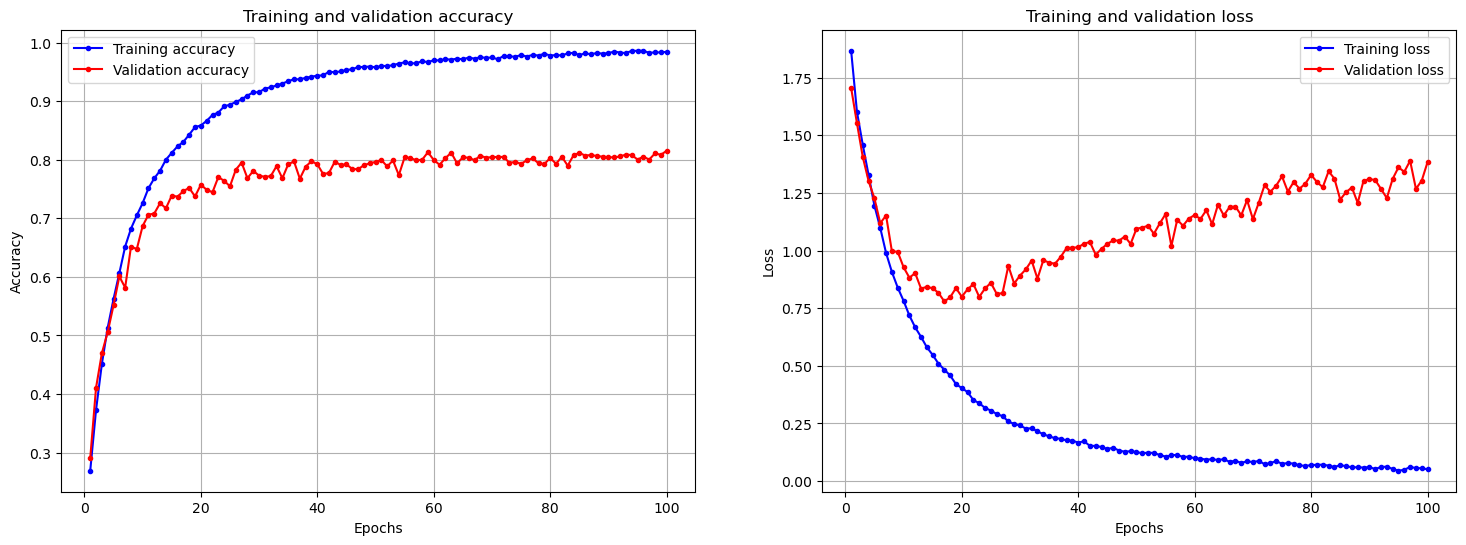

In [12]:
plot_accuracy_and_loss(history)

And finally we'll train our third model with `learning_rate=5e-4`.

In [13]:
model = make_vanilla_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_lr_5e-4_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2237 - loss: 1.9120 - val_accuracy: 0.3820 - val_loss: 1.6066
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3957 - loss: 1.5615 - val_accuracy: 0.4656 - val_loss: 1.3933
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4921 - loss: 1.3296 - val_accuracy: 0.5614 - val_loss: 1.1646
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5967 - loss: 1.0926 - val_accuracy: 0.6302 - val_loss: 0.9895
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6871 - loss: 0.8864 - val_accuracy: 0.6774 - val_loss: 0.9056
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7402 - loss: 0.7246 - val_accuracy: 0.7065 - val_loss: 0.8151
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7874 - loss: 0.5977 - val_accuracy: 0.7417 - val_loss: 0.7574
Epoch 8/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8231 - loss: 0.4940 - 

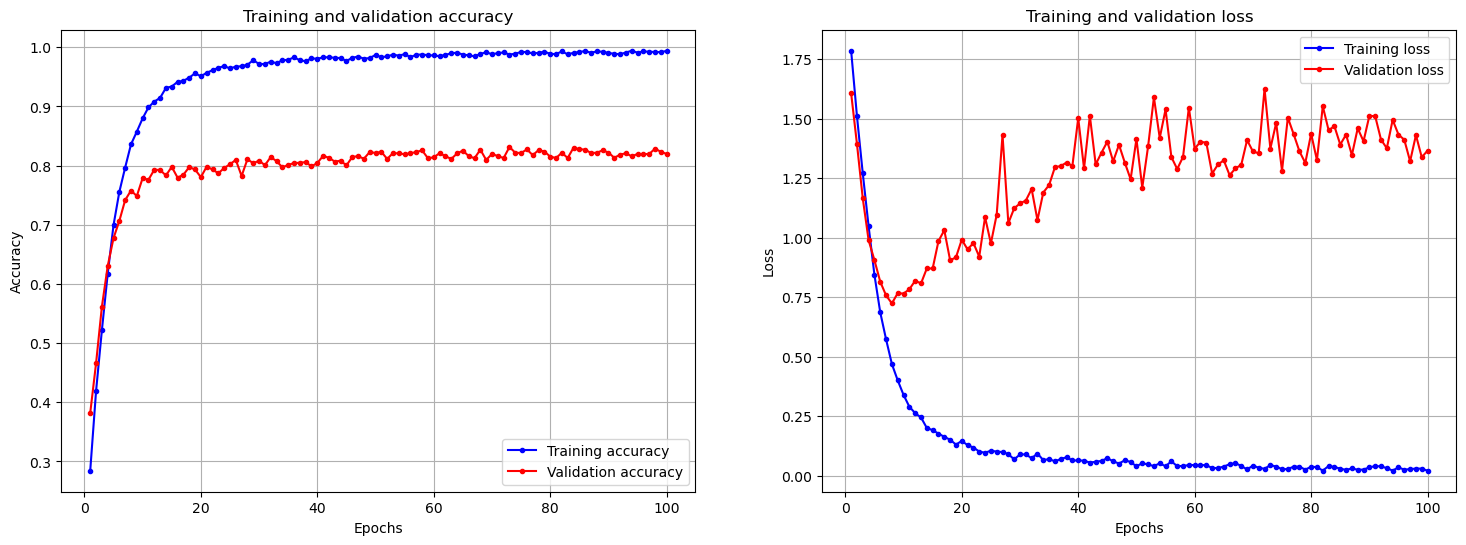

In [14]:
plot_accuracy_and_loss(history)

**Conclusion**: While our original (and largest) learning rate of `1e-3` causes us to overfit too quickly (~ 30 epochs to get near 100% training accuracy), the smallest learning rate of `1e-5` took too long to overfit to the same degree (~ 400 epochs to get near 100% training accuracy). We can see that the second largest learning rate of `5e-4` also causes us to overfits quickly. However, with a learning rate of `1e-4`, we are converging to 100% training accuracy more gradually over 100 epochs.

For now, `1e-4` seems to be a good learning rate. However, this can change as we introduce more regularization via dropout, data augmentation, etc.

### Dropout

One regularization mechanism we can introduce is Dropout. A Dropout layer is parametrized by a dropout probability, which is the proportion of hidden units that are randomly zero'd out during each forward pass. This ensures that our model gets different "views" of the input batch at each epoch. This makes it less likely that our model would overfit to the non-general patterns specific to the training set.

We will add Dropout layers after the `Flatten` layer and in between the `Dense` layers. In addition, we will tune the Dropout rate by trying a few values: `[0.2, 0.3, 0.5]`. In order to do this, we need to alter the model architecture and a new function to instantiate such a model.

In [2]:
def make_dropout_model(drop_rate=0.2):
    inputs = keras.Input(shape=(150, 150, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    outputs = layers.Dense(8, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Let's train our first model with `rate=0.2`.

In [26]:
model = make_dropout_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_dropout_0.2_v2_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1623 - loss: 2.0457 - val_accuracy: 0.3205 - val_loss: 1.7500
Epoch 2/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2781 - loss: 1.8093 - val_accuracy: 0.3476 - val_loss: 1.6548
Epoch 3/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3269 - loss: 1.7201 - val_accuracy: 0.3771 - val_loss: 1.6305
Epoch 4/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3661 - loss: 1.6422 - val_accuracy: 0.4507 - val_loss: 1.4885
Epoch 5/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4155 - loss: 1.5509 - val_accuracy: 0.4689 - val_loss: 1.4301
Epoch 6/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4549 - loss: 1.4592 - val_accuracy: 0.5380 - val_loss: 1.2970
Epoch 7/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4937 - loss: 1.3584 - val_accuracy: 0.5691 - val_loss: 1.2355
Epoch 8/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5204 - loss: 1.3010 -

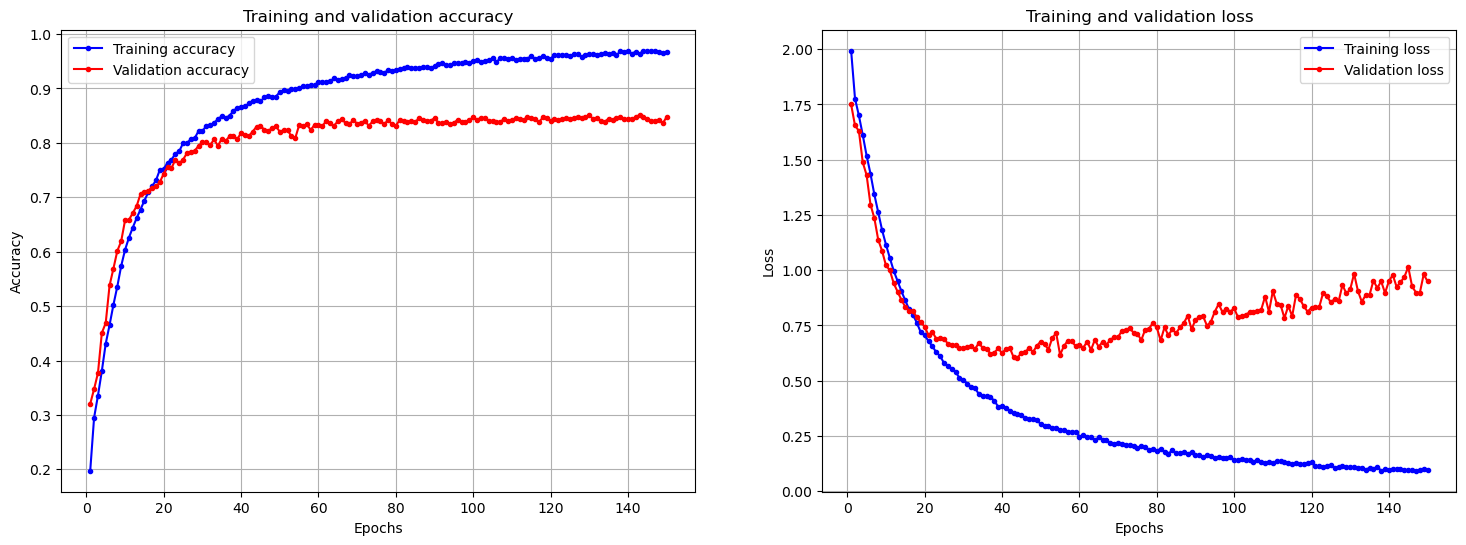

In [27]:
plot_accuracy_and_loss(history)

Now, let's train our second model with `rate=0.3`.

In [29]:
model = make_dropout_model(drop_rate=0.3)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_dropout_0.3_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.1697 - loss: 2.0241 - val_accuracy: 0.2736 - val_loss: 1.7720
Epoch 2/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2802 - loss: 1.8202 - val_accuracy: 0.3553 - val_loss: 1.6606
Epoch 3/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3314 - loss: 1.7335 - val_accuracy: 0.4248 - val_loss: 1.5960
Epoch 4/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3542 - loss: 1.6663 - val_accuracy: 0.4095 - val_loss: 1.5341
Epoch 5/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4092 - loss: 1.5724 - val_accuracy: 0.4717 - val_loss: 1.4605
Epoch 6/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4347 - loss: 1.4976 - val_accuracy: 0.5384 - val_loss: 1.3263
Epoch 7/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4776 - loss: 1.4138 - val_accuracy: 0.5586 - val_loss: 1.2070
Epoch 8/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5129 - loss: 1.3282 

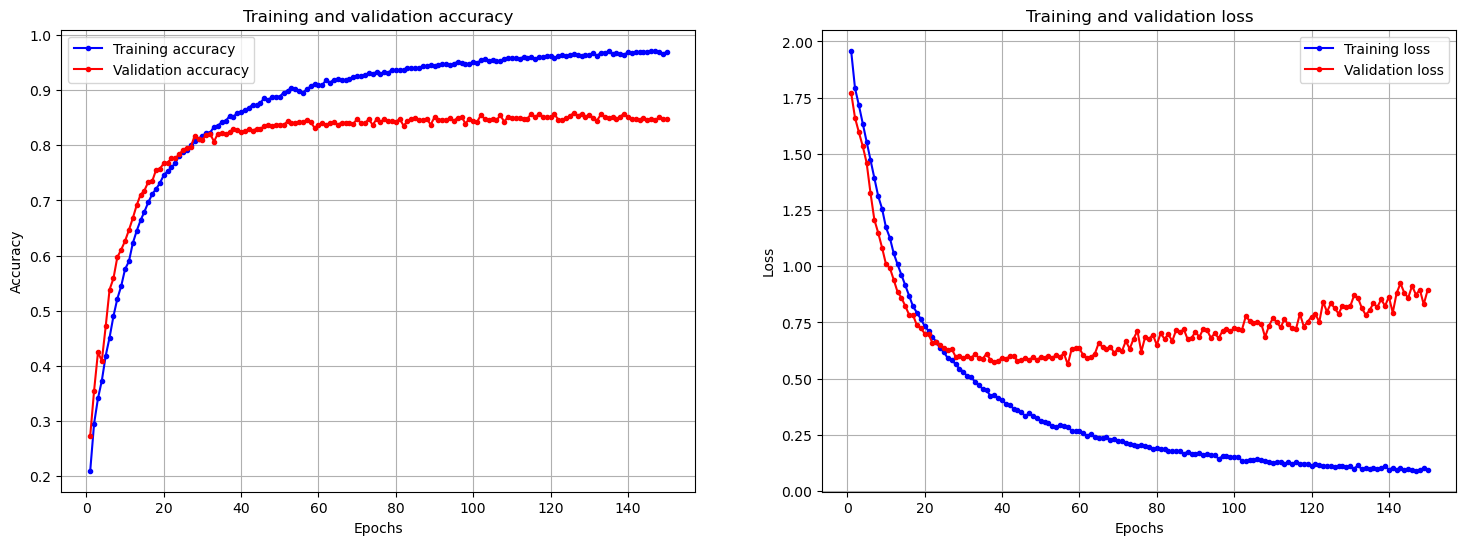

In [30]:
plot_accuracy_and_loss(history)

Now let's train a model with `rate=0.5`.

In [ ]:
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_dropout_0.5_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

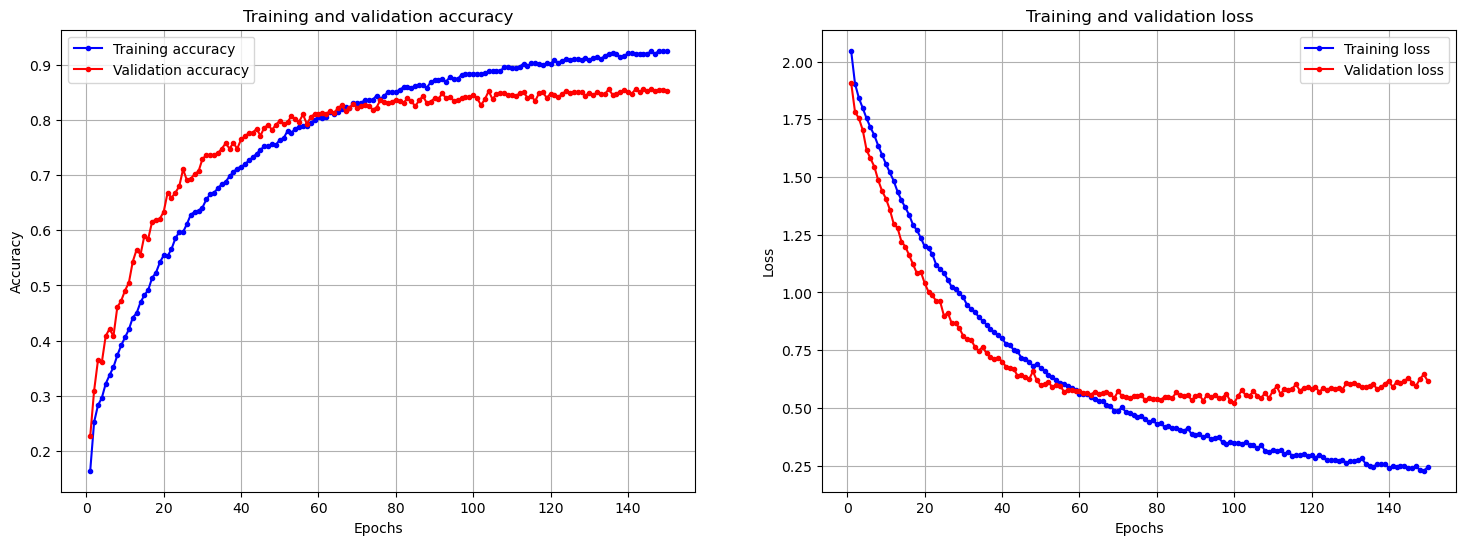

In [32]:
plot_accuracy_and_loss(history)

**Conclusion**: As we can see, Dropout has given us a significant boost in validation accuracy. Our validation accuracy at the lowest loss value using `lr=1e-4` and no Dropout was roughly 74.7%. On the other hand, when adding Dropout with `rate=0.2`, our validation accuracy at the lowest loss value jumps to 83%. With `rate=0.3` and `rate=0.5`, we further improve to 84.6%. Overall, this is roughly a 10% improvement in accuracy.

Although `rate=0.3` and `rate=0.5` achieved the same validation accuracy, we will go with `rate=0.5`, since the validation loss is lower at `0.521` for `rate=0.5` vs. `0.563` for `rate=0.3`.

### Batch size

It is intuitive that reducing batch size induces regularization, since the gradient is less precise with respect to the training dataset. This added noise means that it is harder for our model to overfit the training set.

We'll start by defining a function to load the datasets with a custom batch size. Then, we will try various batch sizes with our already tuned parameters of `learning_rate=1e-4` and `rate=0.5`. Specifically, we will try the following batch sizes: `[8, 16, 64]`.

In [3]:
def load_datasets(batch_size=32):
    new_base_dir = pathlib.Path("../species_data")

    global train_dataset, validation_dataset, test_dataset
    
    train_dataset = image_dataset_from_directory(
        new_base_dir / 'train',
        image_size=(150, 150),
        batch_size=batch_size
    )
    validation_dataset = image_dataset_from_directory(
        new_base_dir / 'valid',
        image_size=(150, 150),
        batch_size=batch_size
    )
    test_dataset = image_dataset_from_directory(
        new_base_dir / 'test',
        image_size=(150, 150),
        batch_size=batch_size
    )

Let's train a model with `batch_size=8`.

In [83]:
load_datasets(batch_size=8)
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_bsize_8_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 11540 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Epoch 1/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1462 - loss: 2.0568 - val_accuracy: 0.3040 - val_loss: 1.8356
Epoch 2/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2637 - loss: 1.8662 - val_accuracy: 0.3319 - val_loss: 1.7135
Epoch 3/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2997 - loss: 1.7930 - val_accuracy: 0.3771 - val_loss: 1.6578
Epoch 4/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3219 - loss: 1.7266 - val_accuracy: 0.4058 - val_loss: 1.5781
Epoch 5/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3593 - loss: 1.6616 - val_accuracy: 0.4309 - val_loss: 1.5089
Epoch 6/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3814 - loss: 1.6096 - val_accuracy: 0.4576 - val_loss: 1.4218
Epoch 7/150
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4122 - loss: 1.5214 

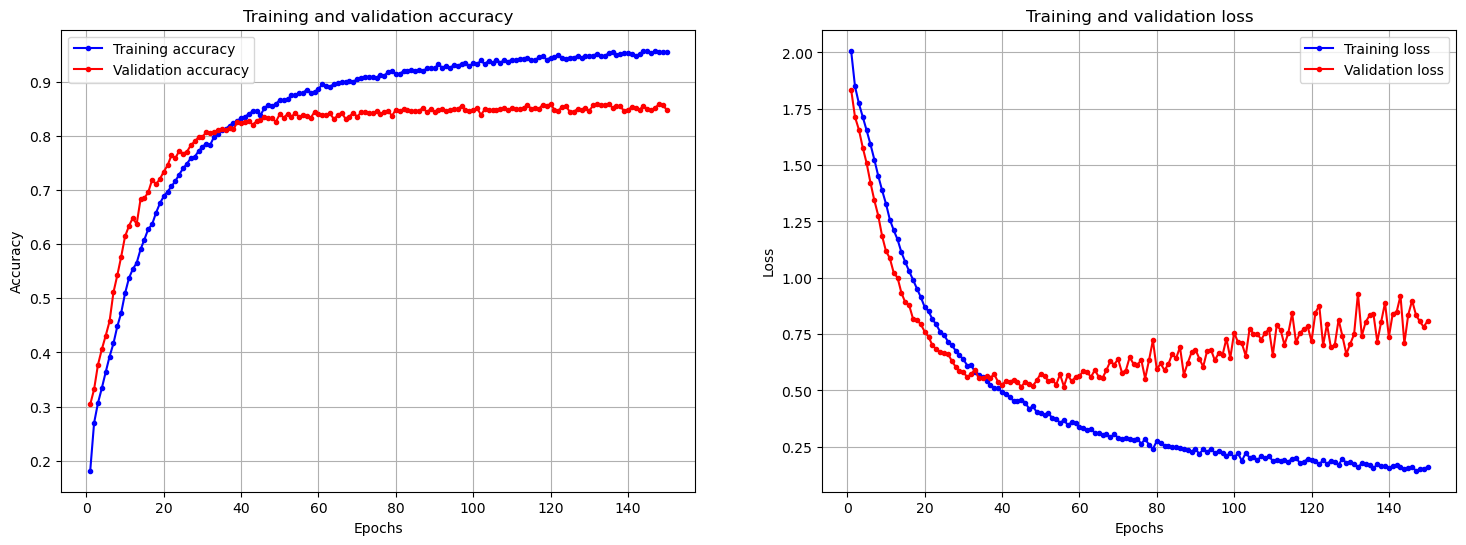

In [84]:
plot_accuracy_and_loss(history)

In [4]:
load_datasets(batch_size=16)
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_bsize_16_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 11540 files belonging to 8 classes.


I0000 00:00:1737919743.044871     624 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Epoch 1/150


I0000 00:00:1737919746.336790    1129 service.cc:148] XLA service 0x7f07f800fb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737919746.337142    1129 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-01-26 14:29:06.386430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737919746.583864    1129 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-26 14:29:06.821735: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 15/722 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2013 - loss: 2.0764

I0000 00:00:1737919749.501007    1129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


722/722 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.1625 - loss: 2.0466 - val_accuracy: 0.3036 - val_loss: 1.7632
Epoch 2/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2553 - loss: 1.8627 - val_accuracy: 0.3250 - val_loss: 1.7102
Epoch 3/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2771 - loss: 1.7998 - val_accuracy: 0.3137 - val_loss: 1.6988
Epoch 4/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2927 - loss: 1.7588 - val_accuracy: 0.3614 - val_loss: 1.6227
Epoch 5/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3081 - loss: 1.7180 - val_accuracy: 0.3917 - val_loss: 1.6083
Epoch 6/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3275 - loss: 1.6811 - val_accuracy: 0.4135 - val_loss: 1.5598
Epoch 7/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3464 - loss: 1.6529 - val_accuracy: 0.4426 - val_loss: 1.5239
Epoch 8/150
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3592 - loss: 1.6208 - val_accuracy: 0.4

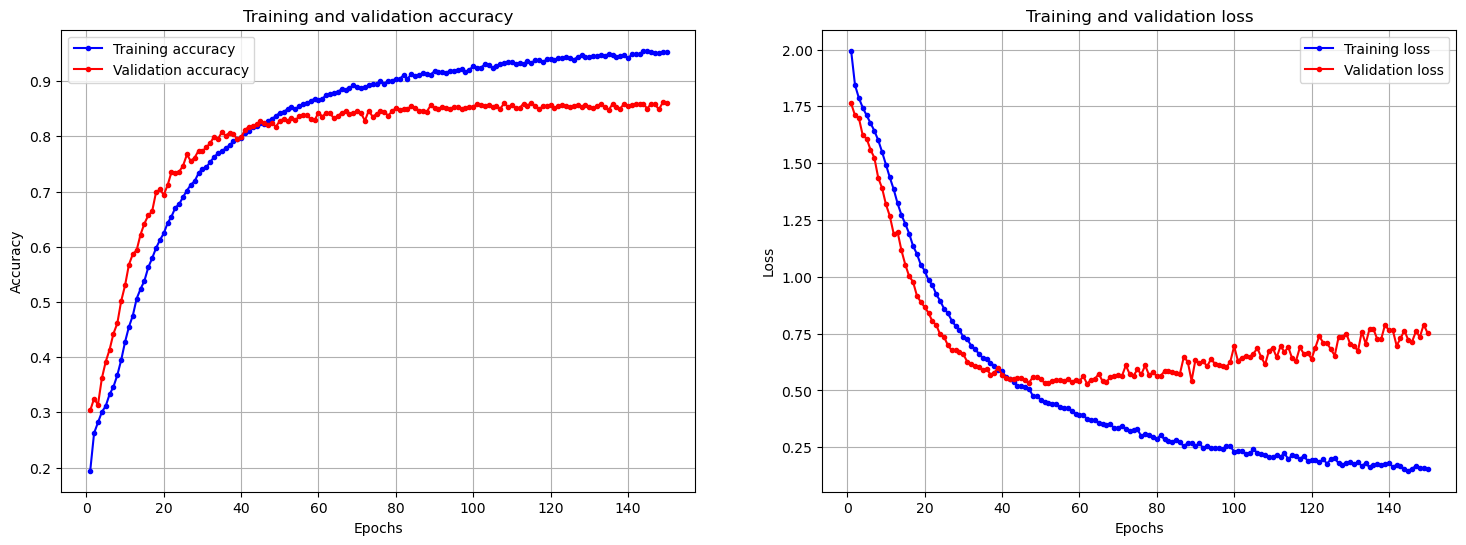

In [7]:
plot_accuracy_and_loss(history)

In [8]:
load_datasets(batch_size=64)
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_bsize_64_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 11540 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Epoch 1/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.1356 - loss: 2.0759 - val_accuracy: 0.2179 - val_loss: 2.0427
Epoch 2/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1957 - loss: 2.0157 - val_accuracy: 0.2983 - val_loss: 1.8771
Epoch 3/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2541 - loss: 1.9143 - val_accuracy: 0.2959 - val_loss: 1.8019
Epoch 4/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2789 - loss: 1.8480 - val_accuracy: 0.3343 - val_loss: 1.7487
Epoch 5/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2898 - loss: 1.8164 - val_accuracy: 0.3565 - val_loss: 1.6996
Epoch 6/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2992 - loss: 1.7747 - val_accuracy: 0.3808 - val_loss: 1.6663
Epoch 7/150
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3126 - loss: 1.7505 - val_a

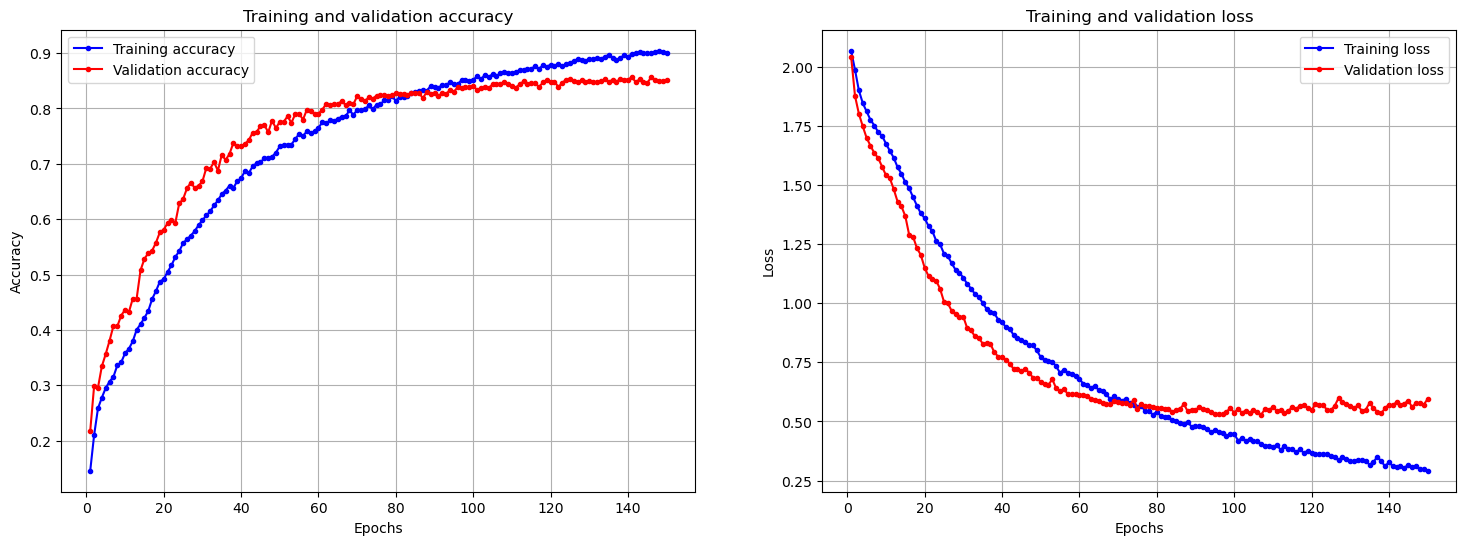

In [9]:
plot_accuracy_and_loss(history)

In [10]:
load_datasets(batch_size=128)
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_bsize_128_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 11540 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Epoch 1/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1323 - loss: 2.0712 - val_accuracy: 0.2231 - val_loss: 2.0462
Epoch 2/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1851 - loss: 2.0262 - val_accuracy: 0.2648 - val_loss: 1.9051
Epoch 3/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2343 - loss: 1.9287 - val_accuracy: 0.2914 - val_loss: 1.8203
Epoch 4/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2607 - loss: 1.8698 - val_accuracy: 0.3161 - val_loss: 1.7618
Epoch 5/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2760 - loss: 1.8336 - val_accuracy: 0.3484 - val_loss: 1.7190
Epoch 6/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2915 - loss: 1.8067 - val_accuracy: 0.3561 - val_loss: 1.6912
Epoch 7/150
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.3094 - loss: 1.7805 - val_accuracy: 0.392

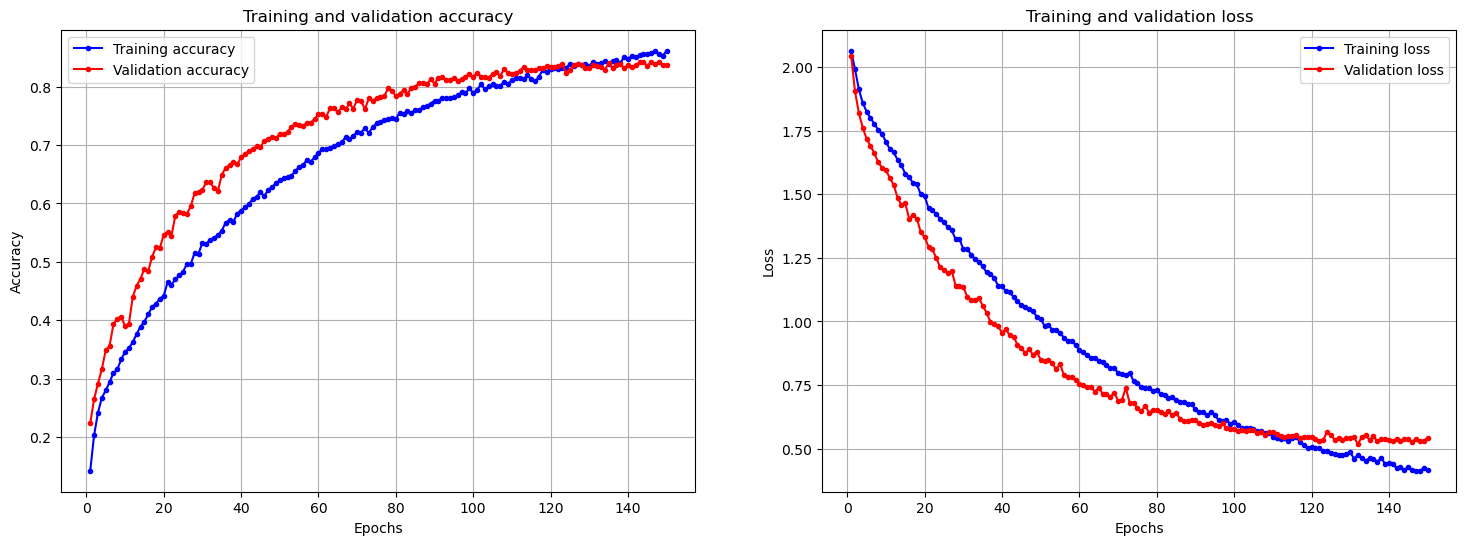

In [11]:
plot_accuracy_and_loss(history)

**Conclusion**: Interestingly, the smaller batch sizes did not affect the model's ability to overfit. Hence, this goes against our initial hypothesis. The smaller batch sizes (`batch_size=8` and `batch_size=16`) tend to have a steeper initial rise in validation accuracy (and correspondingly, a steeper initial fall in validation loss), but overfitting started early, around epoch 40, and the validation accuracy stalls from that point onward. It is also reflected in the validation loss that smaller batch updates are more noisy, as we see a fluctuating pattern in the loss. On the other hand, the larger batch sizes (`batch_size=64` and `batch_size=128`) has validation losses that decrease to roughly the same level and then stall.

The best validation accuracy of 0.846 is still achieved with `batch_size=32`, with `batch_size=64` coming in at a close second with a validation accuracy of 0.845. Out of these two, the model using `batch_size=32` also has a lower validation loss, so we will stick with that model.

### Batch normalization

Batch normalization is a technique where we center outputs of a layer around 0 and rescale inputs to have a variance of 1. Since the inputs to each layer are standardized, batch normalization helps to stabilize the training process of the model.

We'll simply add a `BatchNormalization` layer after each convolutional and dense layer.

In [25]:
def make_batchnorm_model(drop_rate=0.2):
    inputs = keras.Input(shape=(150, 150, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(drop_rate)(x)
    outputs = layers.Dense(8, activation='softmax')(x)  
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
load_datasets(batch_size=32)
model = make_dropout_model(drop_rate=0.5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_path = pathlib.Path('custom_batchnorm_all_{epoch:02d}_{val_accuracy:.3f}_{val_loss:.3f}.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= model_dir / model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 11540 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Found 2474 files belonging to 8 classes.
Epoch 1/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1452 - loss: 2.0619 - val_accuracy: 0.2506 - val_loss: 1.9393
Epoch 2/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2386 - loss: 1.9352 - val_accuracy: 0.2850 - val_loss: 1.7906
Epoch 3/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2601 - loss: 1.8478 - val_accuracy: 0.3420 - val_loss: 1.7505
Epoch 4/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2919 - loss: 1.8010 - val_accuracy: 0.3812 - val_loss: 1.6817
Epoch 5/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3058 - loss: 1.7604 - val_accuracy: 0.3989 - val_loss: 1.6533
Epoch 6/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3195 - loss: 1.7272 - val_accuracy: 0.4171 - val_loss: 1.6119
Epoch 7/200
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3459 - loss: 1.6881 - val_a

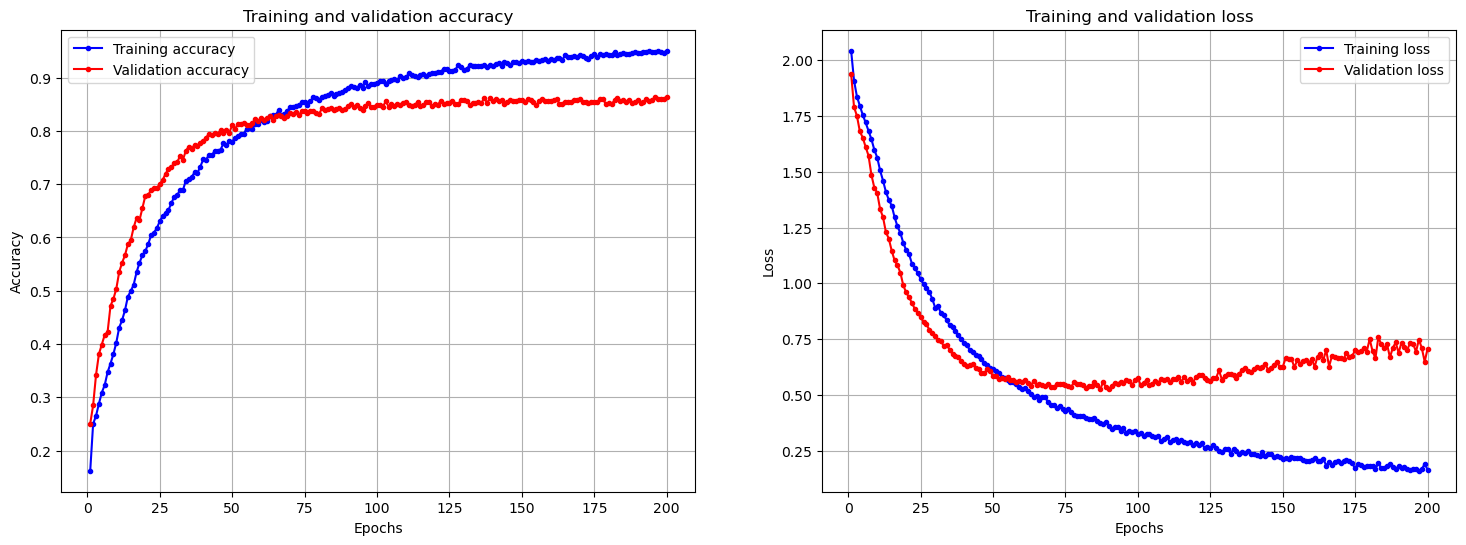

In [27]:
plot_accuracy_and_loss(history)

**Conclusion**: In this case, batch normalization did not provide an improvement in our model's validation accuracy. In addition, we have a higher validation loss than without batch normalization, so we will continue without it.

## Testing our final model

Now that we have done a fair amount of hyperparameter tuning, our best model has the following properties:
- `learning_rate=1e-4`
- `rate=0.5` (dropout probability)
- `batch_size=32`
- No batch normalization

We do not need to retrain a model with these parameters, because we've been using model checkpointing during our training runs. Our best model has a validation accuracy of `0.846` and a validation loss of `0.521`. Let's load the model now and evaluate it on the test set. 

In [31]:
model_file = 'custom_dropout_0.5_100_0.846_0.521.keras'
model_path = model_dir / model_file

final_model = keras.models.load_model(model_path)
test_loss, test_acc = final_model.evaluate(test_dataset)

print(f'Test accuracy: {test_acc:.3f}')
print(f'Test loss: {test_loss:.3f}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8401 - loss: 0.5700
Test accuracy: 0.846
Test loss: 0.544


As expected, our test accuracy is very close to (and in fact, equal) to our validation accuracy. Thus, we have indication that our model would be able to classify new such images of these animal species, captured by similar camera traps within similar environments, roughly 85% of the time.